In [1]:
from hlm_basic.ssn import GenerateNetwork, UpstreamArea
from hlm_basic.watershed import Watershed
from hlm_basic.tools import GetForcing, Set_InitialConditions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
l_id, connectivity, h_order, nextlink = GenerateNetwork(5)
n_hills = len(connectivity)
a_hill = 0.5 * 0.5 #km2
A_h = np.array([a_hill*10**6 for i in range(n_hills)]) #m2
L_i = np.array([0.5*10**3 for i in range(n_hills)])  #m
A_i = UpstreamArea(a_hill, connectivity, h_order) #km2

In [3]:
forcing, raw_data = GetForcing("../data/rainfall/2010_timeseries.csv", '2010-06-01','2010-08-01')
te = len(forcing)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)

In [4]:
SSN1 = Watershed(Model=190)
# SSN1.global_params[4] = 0.2
SSN1.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN1.initialize(q=q, s_p =s_p, s_s=s_s)
dc_nodam190 = SSN1.Run_190( [0, te-1], forcing, rtol=1e-4)

Model 190 is being used!
87839

In [5]:
SSN2 = Watershed(Model=254)
SSN2.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN2.initialize(q=q, s_p=s_p, s_t=s_t, s_s=s_s)
dc_nodam254 = SSN2.Run_254( [0, te-1],forcing, rtol=1e-4)

Model 254 is being used!
87839

In [6]:
from ifis_tools.asynch_manager import hlm_dat_process
hlm_190 = hlm_dat_process()
hlm_190.read_dat_file('../data/asynch/ssn6_190.dat')
data = hlm_190.dat_record2pandas(0, date1='2010-06-01 00:00', freq='5min')
time190 = data[0].values
outlet190 = data[2].values

hlm_254 = hlm_dat_process()
hlm_254.read_dat_file('../data/asynch/ssn6_254.dat')
data = hlm_254.dat_record2pandas(0, date1='2010-06-01 00:00', freq='5min')
time254 = data[0].values
outlet254 = data[2].values

Unable to import WMF, cant create basins whit it


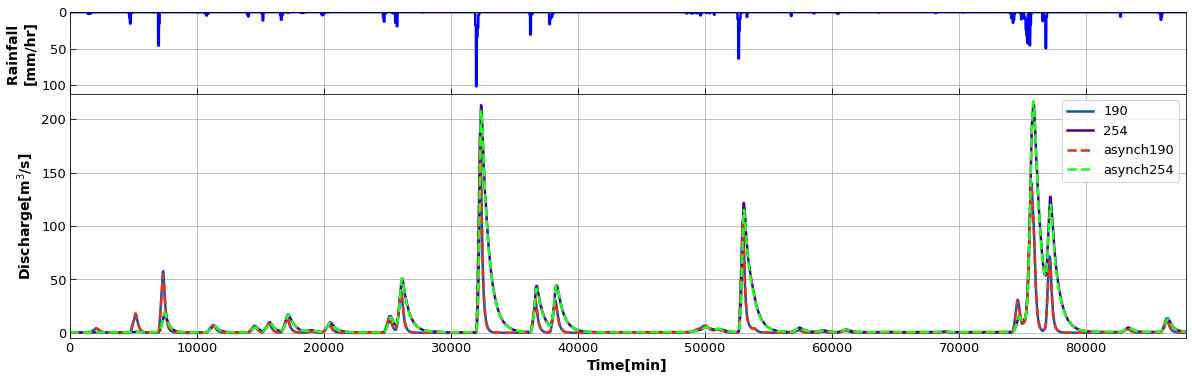

In [7]:
import matplotlib
matplotlib.rcParams.update({'font.size': 13,'axes.labelweight':'bold','axes.labelsize':14,\
                            'ytick.major.size':6,'xtick.major.size':6,'xtick.direction':'in','ytick.direction':'in',\
                            'lines.linewidth':2.5})
fig, ax = plt.subplots(2, 1,figsize=(20, 6), gridspec_kw={'height_ratios':[1, 3]}, sharex=True)

ax[0].plot(range(len(forcing)), forcing, alpha=1, color='b')
ax[0].set_ylim([max(forcing)*1.1, 0])
ax[0].set_ylabel('Rainfall \n[mm/hr]')
ax[0].grid()
ax[1].plot(dc_nodam190.index, dc_nodam190['0'].values, c='#005AB5', label='190')
ax[1].plot(dc_nodam254.index, dc_nodam254['0'].values, c='#4B0092', label='254')
ax[1].plot(time190, outlet190,'--', c='#DC3220', label='asynch190')
ax[1].plot(time254, outlet254,'--', c='#1AFF1A',label='asynch254')
ax[1].set(xlabel='Time[min]', ylabel='Discharge[m$^3$/s]')
ax[1].set_xlim([0, dc_nodam190.index.max()])
ax[1].set_ylim([-5, dc_nodam254['0'].values.max()*1.05])
ax[1].set_yticks(np.arange(0, 250, 50))
ax[1].legend()
ax[1].grid()
plt.subplots_adjust(hspace=0)
# fig.savefig("../data/asynch/all_comparision.png")

## Prepare ASYNCH inputs

In [ ]:
path_save = "../data/asynch/"
with open(path_save+'rainfall.ustr', 'w') as ustr:
    count = len(raw_data)
    ustr.write(str(count))
    ustr.write('\n')
    time=0
    for data in raw_data.val.values:
        ustr.write(f'{time} {data}\n')
        time +=60

In [ ]:
with open(path_save+'ssn6.prm', 'w') as prm:
    prm.write(str(len(connectivity)))
    prm.write('\n')
    for i in range(len(connectivity)):
        prm.write(f'{i}\n')
        prm.write(f'{A_i[i]} ')
        prm.write(f'{L_i[i]/(10**3)} ')
        prm.write(f'{A_h[i]/(10**6)}\n')   

In [ ]:
with open(path_save+'ssn6.rvr','w') as rvr:
    rvr.write(str(len(connectivity)))
    rvr.write('\n')
    for i in range(len(connectivity)):
        link = i
        childs = connectivity[i]
        rvr.write(f'{link}')
        rvr.write(f'\n{len(childs)} ')
        if len(childs) != 0:
            for j in childs:
                rvr.write(f'{j} ')
        else:pass
        rvr.write('\n')

In [ ]:
path_save = "../data/asynch/"
with open(path_save+'190.ini', 'w') as ini:
    ini.write(str(190))
    ini.write('\n')
    ini.write(str(len(connectivity)))
    ini.write('\n')
    j =0
    for link_id in l_id:
        ini.write(f'{link_id}\n')
        ini.write(f'{q[j]} {s_p[j]} {s_s[j]}\n')
        j +=1

In [ ]:
with open(path_save+'254.ini', 'w') as ini:
    ini.write(str(254))
    ini.write('\n')
    ini.write(str(len(connectivity)))
    ini.write('\n')
    j =0
    for link_id in l_id:
        ini.write(f'{link_id}\n')
        ini.write(f'{q[j]} {s_p[j]} {s_t[j]} {s_s[j]}\n')
        j +=1